# Superpixel learning


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = set_device(verbose=True)

Using backend: pytorch


cuda available


# MNIST Superpixel 

In [2]:
from molecules import MoleculeDatasetDGL 

dataset = MoleculeDatasetDGL('ZINC') 
trainset, valset, testset = dataset.train, dataset.val, dataset.test

preparing 10000 graphs for the TRAIN set...
preparing 1000 graphs for the VAL set...
preparing 1000 graphs for the TEST set...
Time taken: 102.8482s


## Visualise the dataset

Label: tensor([1.7546])
graph: DGLGraph(num_nodes=29, num_edges=64,
         ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
Largest eigenvalue: 1.9934743181254733
Smallest eigenvalue: 1.7300757183620266e-16


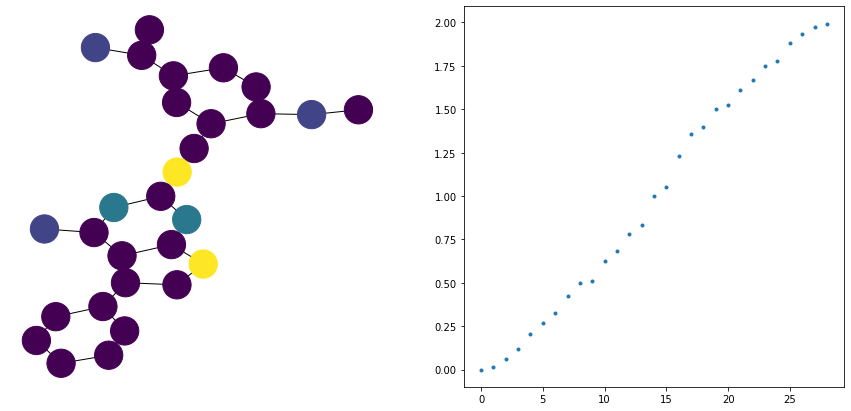

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(50)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),
        node_color=g_demo.ndata['feat'],
        node_size=800 )

print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()

# Model definition for training

In [4]:
from model_ZINC import Cheb_ZINC
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 128
k = 2
n_classes = 1

net = Cheb_ZINC(
    dataset.num_atom_type, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="mean"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

Cheb_ZINC(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (fc): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): Cheb_Conv(
      (fc): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): Cheb_Conv(
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
  (embedding_h): Embedding(64, 128)
)


In [5]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_superpix_overfit'))

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=500,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)

loss_func = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)

epoch_losses = []

, (torch.ones(2048)*1.4).to(device)

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (bGraph, label) in enumerate(data_loader):
            bGraph, label = bGraph.to(device), label.to(device)
            
            #lmax = normalized_laplacian(bGraph)
            #print(lmax)
            output = model(bGraph, 
                           bGraph.ndata.pop('feat').view(-1,1).to(device))
            loss = loss_func(output, label.view_as(output).to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # put a max - min error?

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - of : {} data in {:.1f}s".format(
                epoch, epoch_loss, val_loss, len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [10]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_loss = 0
    tot_pred = []

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = model(Bgraph, Bgraph.ndata['feat'].view(-1,1).float())
            # sum up batch loss
            test_loss += loss_func(output, label.view_as(output).to(device)).item()
            tot_loss += test_loss
            
    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, total loss: {:.4f} of {} molecules \n'.format(
            test_loss,tot_loss, len(test_loader.dataset)))

    else:
        return test_loss#, tot_loss

## Training time

In [11]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

Epoch 0 loss - train 0.6774 - val 0.6212 - of : 10000 data in 93.3s
Epoch 1 loss - train 0.6310 - val 0.6243 - of : 10000 data in 94.2s
Epoch 2 loss - train 0.6127 - val 0.5630 - of : 10000 data in 94.2s
Epoch 3 loss - train 0.6022 - val 0.5678 - of : 10000 data in 93.3s
Epoch 4 loss - train 0.5933 - val 0.5582 - of : 10000 data in 93.3s
Epoch 5 loss - train 0.5761 - val 0.5480 - of : 10000 data in 93.2s
Epoch 6 loss - train 0.5668 - val 0.5252 - of : 10000 data in 93.1s
Epoch 7 loss - train 0.5599 - val 0.5693 - of : 10000 data in 93.2s
Epoch 8 loss - train 0.5441 - val 0.5154 - of : 10000 data in 93.0s
Epoch 9 loss - train 0.5537 - val 0.5126 - of : 10000 data in 94.1s
Epoch 10 loss - train 0.5465 - val 0.5141 - of : 10000 data in 100.4s
Epoch 11 loss - train 0.5361 - val 0.5999 - of : 10000 data in 99.0s
Epoch 12 loss - train 0.5325 - val 0.5040 - of : 10000 data in 99.3s
Epoch 13 loss - train 0.5145 - val 0.5449 - of : 10000 data in 99.7s
Epoch 14 loss - train 0.5151 - val 0.4914 -

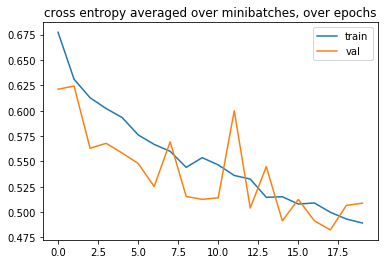

In [12]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [13]:
torch.cuda.empty_cache()

## Test Metrics

In [14]:
test(net,device,test_loader)
torch.cuda.empty_cache()

/home/axel/anaconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)



 Average loss per epoch: 0.5279, total loss: 1.5636 of 1000 molecules 



In [15]:
def preds_f(model, device, data_loader, verbose=True):
    model.eval()

    output = torch.Tensor([]).to(device)

    with torch.no_grad():
        for iter, (Bgraph, label) in enumerate(data_loader):
            Bgraph, label = Bgraph.to(device), label.to(device)

            output = torch.cat((output,model(Bgraph, Bgraph.ndata['feat'].view(-1,1).float())),0)

        return output

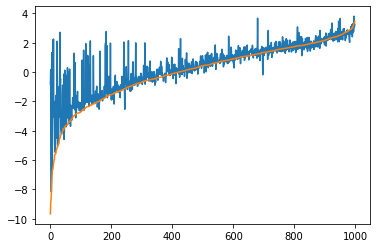

In [16]:
import numpy as np
preds = preds_f(net,device,test_loader).cpu()
plt.plot([x for _,x in sorted(zip(testset.graph_labels,preds))])
plt.plot(sorted(testset.graph_labels))

## Saving

In [ ]:
from utils import save_model

#save_model("Zinc_mean", net)